# Libraries

In [40]:
# activate line execution
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:

# general
import numpy as np
import pandas as pd


# import custom libraries
import sys
import os
import tqdm
import pickle
import yaml

In [42]:

# plotly
import plotly.express as px  # (version 4.7.0 or higher)
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt


In [43]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.preprocessing import OneHotEncoder

In [44]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Header

* Specify the dataset
* Make sure there is a data config in `configs/data/{DATASET}.yaml`
    * it must contain `name`, `path_raw`.

In [61]:
list_datasets = ['p12','p19','mimic','sim-l0.2-d16']

DATASET = 'sim-l0.2-d16'

config_data = yaml.safe_load(open(f'../configs/data/{DATASET}.yaml'))

PATH_RAW = config_data['path_raw']
if not os.path.isabs(PATH_RAW):
    PATH_RAW = '../' + PATH_RAW


if 'path_processed' not in config_data:
    PATH_PROCESSED = PATH_RAW + f'processed/{DATASET}/'
    config_data['path_processed'] = PATH_PROCESSED
else:
    PATH_PROCESSED = config_data['path_processed']
    
if not os.path.isabs(PATH_PROCESSED):
    PATH_PROCESSED = '../' + PATH_PROCESSED
# create path_processed if it does not exist
if not os.path.exists(PATH_PROCESSED):    
    os.makedirs(PATH_PROCESSED)

# with open(f'../configs/data/{DATASET}.yaml', 'w') as file:
#     documents = yaml.dump(config_data, file)


# if paths are relative, add prefix '../'



# This will shuffle the order of clinical time series in the image
SUFFLE_VARS = True


# for TimEHR format
GRAN = config_data['granularity'] # granularity of the image (in hours)
IMG_SIZE = config_data['img_size'] # granularity of the image
N_SPLIT = config_data['n_split'] # number of splits for the cross-validation
SEED = config_data['seed'] # seed for the random number generator

print(f"DATASET: {DATASET}")
print(f"PATH_RAW: {PATH_RAW}")
print(f"PATH_PROCESSED: {PATH_PROCESSED}")
print(f"GRAN: {GRAN}")
print(f"IMG_SIZE: {IMG_SIZE}")
print(f"N_SPLIT: {N_SPLIT}")
print(f"SEED: {SEED}")

DATASET: sim-l0.2-d16
PATH_RAW: .././data/raw
PATH_PROCESSED: .././data/processed/sim-l0.2-d16
GRAN: 1
IMG_SIZE: 64
N_SPLIT: 1
SEED: 42


# Processed Format

In [62]:

if DATASET=='p12':
    print('### Handling P12 dataset')
    df = pd.read_csv(PATH_RAW+f'/{DATASET}.csv', index_col=None)
    
    print('# Number of patients:',df.RecordID.nunique())

    # convert time to hours
    df['Time'] = df['Time'].apply(lambda x:       int(x.split(':')[0]) + int(x.split(':')[1])/60      )

    # rename column
    df.rename(columns={'In-hospital_death':'outcome','RecordID':'id','Time':'timepoint'}, inplace=True)
    
    print('# Prevelence of in-hospital mortality: ', df.outcome.mean())

    # columns handling
    all_cols = df.columns

    cols_id = ['id','timepoint']
    cols_outcome = ['outcome']
    cols_demo = ['Age','Gender','Height','ICUType','Weight']
    demo_types = ['continuous','binary','continuous','categorical','continuous']
    cols_vital = ['HR','NIDiasABP', 'NIMAP', 'NISysABP','RespRate', 'Temp','DiasABP','MAP','SysABP', 'GCS']
    cols_lab = [ 'BUN', 'Creatinine', 'Glucose', 'HCO3', 'HCT', 'K', 'Mg','Na', 'Platelets','Urine', 'WBC','FiO2', 'PaCO2', 'PaO2', 'SaO2', 'pH', 'ALP', 'ALT',
        'AST', 'Albumin', 'Bilirubin', 'Lactate', 'Cholesterol', 'TroponinI',
        'TroponinT']
    # cols_ignore = ['MechVent','Hospital'] # will be ignored


    # some demo vars are -1 which means missing
    df[cols_demo] = df[cols_demo].replace(-1,np.nan)

    # median impuation for missing values
    df[cols_demo] = df[cols_demo].fillna(df[cols_demo].median())
    


    
elif DATASET in ['p19']:
    print('### Handling P19 dataset')


    # data from hispital A and B
    df_A = pd.read_csv(PATH_RAW+'/df_A.csv')#.merge(df_filenames_A,on='id')
    df_A['Hospital']=0

    df_B = pd.read_csv(PATH_RAW+'/df_B.csv')#.merge(df_filenames_B,on='id')
    df_B['Hospital']=1

    # combine two datasets into one
    df_B['id']=df_B['id']+len(df_A['id'].unique())
    df=pd.concat([df_A,df_B])

    print('# Number of patients:',df.id.nunique())
    
    pos_ids = df[df.SepsisLabel==1].id.unique()    

    print('# Prevelence of sepsis:',len(pos_ids)/df.id.nunique())
    # IMPORTANT
    # we shift the label 6 hours before. This is because the label at each row indicates sepsis for the next 6 hours
    df['SepsisLabel'] = df.groupby('id')['SepsisLabel'].shift(6, fill_value=0).astype(int)

    # we remove the rows with label 1. Our goal is to predict sepsis patients, not the detection of onset of sepsis   
    df = df[df.SepsisLabel!=1]

    # if patient is septic, we set the label to 1 across all rows
    df.loc[df.id.isin(pos_ids),'SepsisLabel'] = 1
    df.loc[~df.id.isin(pos_ids),'SepsisLabel'] = 0
    


    # rename column
    df.rename(columns={'SepsisLabel':'outcome','ICULOS':'timepoint'}, inplace=True)


    print('# Distribution of LOS: brefore removing patients with LOS>64')
    print('# df.shape:',df.shape)
    print(df.groupby('id')['timepoint'].max().describe())
    # df['Time'].hist(bins=100)
    
    # we only keep first 64 hours
    df = df[df.timepoint<=63]

    print('# Distribution of LOS: after removing patients with LOS>64')
    print('# df.shape:',df.shape)
    print(df.groupby('id')['timepoint'].max().describe())
    # df['timepoint'].hist(bins=100)

    
    # columns handling
    all_cols = df.columns

    cols_id = ['id','timepoint']
    cols_outcome = ['outcome']
    cols_demo = ['Age','Gender','HospAdmTime']
    demo_types = ['continuous','binary','continuous']
    cols_vital = [ 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp'] 
    cols_lab = [ 
        'BUN','Creatinine', 'Glucose',  'HCO3', 'Potassium','Magnesium',
        'Hct','Platelets','WBC',
        'FiO2', 'PaCO2','pH','SaO2',        
         'Alkalinephos','AST', 'Bilirubin_total','Bilirubin_direct',
         'Lactate',  'TroponinI',
        'Hgb', 'Chloride', 
          'Phosphate', 'Calcium',    'PTT',   'Fibrinogen' ]
    # cols_ignore = ['EtCO2','BaseExcess','Unit1', 'Unit2','Hospital'] # will be ignored

elif DATASET in ['mimic']:

    df = pd.read_csv(PATH_RAW+'/df_mimic.csv', index_col=None)

    # rename column
    df.rename(columns={'Label':'outcome','RecordID':'id','Time':'timepoint'}, inplace=True)
    # columns handling
    all_cols = df.columns
 
    cols_id = ['id','timepoint']
    cols_outcome = ['outcome']
    cols_demo = ['Age','Height','Weight']
    demo_types = ['continuous','continuous','continuous']
    cols_vital = ['heartrate', 'sysbp', 'diasbp', 'meanbp',
        'resprate', 'tempc', 'spo2']
    cols_lab = [ 'glucose_chart',  'endotrachflag', 'bg_so2', 'bg_po2', 'bg_pco2',
        'bg_pao2fio2ratio', 'bg_ph', 'bg_baseexcess', 'bg_bicarbonate',
        'bg_totalco2', 'bg_hematocrit', 'bg_hemoglobin', 'bg_carboxyhemoglobin',
        'bg_methemoglobin', 'bg_chloride', 'bg_calcium', 'bg_temperature',
        'bg_potassium', 'bg_sodium', 'bg_lactate', 'bg_glucose', 'aniongap',
        'albumin', 'bands', 'bicarbonate', 'bilirubin', 'creatinine',
        'chloride', 'glucose', 'hematocrit', 'hemoglobin', 'lactate',
        'platelet', 'potassium', 'ptt', 'inr', 'pt', 'sodium', 'bun', 'wbc',
        'urineoutput']
    # cols_ignore = []

elif 'sim' in DATASET:
    
    df = pd.read_csv(PATH_RAW+f'/{DATASET}.csv')

    if '16' in DATASET:
        seq_len = 16
    elif '32' in DATASET:
        seq_len = 32
    elif '64' in DATASET:
        seq_len = 64
    elif '128' in DATASET:
        seq_len = 128
    # seq_len = 128 if '128' in DATASET else 64

    

    # MODE 1: disjoint

    a = len(df)//seq_len*seq_len
    df = df.iloc[:a]
    # simplify above

    var_names = df.columns.tolist()

    df['timepoint'] =  np.tile(np.arange(seq_len),len(df)//seq_len)
    df['id'] = np.repeat(np.arange(len(df)//seq_len),seq_len)
    
    


    # continue
    
    # set age randomly
    df['Age'] = np.random.randint(20,80,len(df))  # dummy    
    df['outcome'] = 0
    all_cols = df.columns

    cols_id = ['id','timepoint']
    cols_outcome = ['outcome'] # dummy
    cols_demo = ['Age'] # dummy
    demo_types = ['continuous'] # dummy
    cols_vital = var_names
    cols_lab = []
    cols_ignore = []




print('# Distribution of maximum time:')
print(df.groupby('id')['timepoint'].max().describe())

# Distribution of maximum time:
count    80000.0
mean        15.0
std          0.0
min         15.0
25%         15.0
50%         15.0
75%         15.0
max         15.0
Name: timepoint, dtype: float64


In [63]:
remaining_cols = list(set(all_cols) - set(cols_id) - set(cols_outcome) - set(cols_demo) - set(cols_vital) - set(cols_lab) )


print("remaining_cols: ", remaining_cols)


remaining_cols:  []


In [64]:
state_vars = cols_vital+cols_lab
state_vars
if SUFFLE_VARS:
    np.random.seed(SEED)
    np.random.shuffle(state_vars)

state_vars
demo_vars = cols_demo

dict_map_states = {label:i for i,label in enumerate(state_vars)}

dict_map_demos = {k:i for i,k in enumerate(cols_demo)}
dict_map_demos


print("number of state variables (vital+lab): ", len(state_vars))
print("number of demographic variables: ", len(demo_vars))

config_data['ts_vars'] = state_vars
config_data['static_vars'] = demo_vars

config_data['n_ts'] = len(state_vars)
config_data['n_static'] = len(demo_vars)
config_data['static_types'] = demo_types



# d_conditional is the number of dimensions after transforming static data
d_conditional = 1 # for outcome

for var,type in zip(demo_vars,demo_types):
    if type=='binary':
        d_conditional += 1
    elif type=='categorical':
        d_conditional += len(df[var].unique())
    elif type=='continuous':
        d_conditional += 1

config_data['d_conditional'] = d_conditional


['var_0',
 'var_1',
 'var_2',
 'var_3',
 'var_4',
 'var_5',
 'var_6',
 'var_7',
 'var_8',
 'var_9',
 'var_10',
 'var_11',
 'var_12',
 'var_13',
 'var_14',
 'var_15']

['var_0',
 'var_1',
 'var_5',
 'var_14',
 'var_13',
 'var_11',
 'var_8',
 'var_9',
 'var_2',
 'var_15',
 'var_4',
 'var_7',
 'var_10',
 'var_12',
 'var_3',
 'var_6']

{'Age': 0}

number of state variables (vital+lab):  16
number of demographic variables:  1


In [65]:
config_data

{'granularity': 1,
 'img_size': 64,
 'n_split': 1,
 'name': 'sim',
 'path_processed': './data/processed/sim-l0.2-d16',
 'path_raw': './data/raw',
 'seed': 42,
 'ts_vars': ['var_0',
  'var_1',
  'var_5',
  'var_14',
  'var_13',
  'var_11',
  'var_8',
  'var_9',
  'var_2',
  'var_15',
  'var_4',
  'var_7',
  'var_10',
  'var_12',
  'var_3',
  'var_6'],
 'static_vars': ['Age'],
 'n_ts': 16,
 'n_static': 1,
 'static_types': ['continuous'],
 'd_conditional': 2}

In [66]:
# split df to df_ts and df_static

df['id'] = df['id'].astype(int)
df['outcome'] = df['outcome'].astype(int)

df_ts = df[['id','timepoint']+state_vars].copy()
df_static = df[['id']+cols_demo+cols_outcome].drop_duplicates(subset='id').copy()

df_ts.shape, df_static.shape

df_ts.head()
df_static.head()

((1280000, 18), (80000, 3))

,id,timepoint,var_0,var_1,var_5,var_14,var_13,var_11,var_8,var_9,var_2,var_15,var_4,var_7,var_10,var_12,var_3,var_6
0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.780745,-0.096466,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1,NaN,0.494321,NaN,0.490799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.10319,NaN,NaN,NaN,NaN,NaN,NaN
3,0,3,NaN,NaN,NaN,NaN,0.310968,0.783479,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.311633
4,0,4,NaN,NaN,1.051831,NaN,NaN,NaN,NaN,NaN,-1.302450,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,id,Age,outcome
0,0,34,0
16,1,34,0
32,2,78,0
48,3,78,0
64,4,52,0


In [67]:
# check for missing rate

df_ts.isnull().sum()/(df_ts.shape[0]*df_ts.shape[1])*100

df_static.isnull().sum()/(df_static.shape[0]*df_static.shape[1])*100

print("overall missingness rate(%): ", df_ts.isnull().sum().sum()/(df_ts.shape[0]*df_ts.shape[1])*100)

# bar plot of missing rate for each variable using plotly

missing_rate = df_ts.isnull().mean().sort_values(ascending=False)
missing_rate = missing_rate[missing_rate>0]

fig = px.bar(x=missing_rate.index, y=missing_rate.values*100, labels={'x':'Variable','y':'Missing rate (%)'}, title='Missing rate for each variable')
fig.show()

id           0.000000
timepoint    0.000000
var_0        4.551259
var_1        4.550256
var_5        4.551263
var_14       4.547860
var_13       4.550299
var_11       4.549253
var_8        4.550130
var_9        4.548468
var_2        4.550786
var_15       4.549588
var_4        4.550590
var_7        4.547504
var_10       4.550894
var_12       4.549006
var_3        4.549913
var_6        4.547674
dtype: float64

id         0.0
Age        0.0
outcome    0.0
dtype: float64

overall missingness rate(%):  72.79474392361112


In [68]:


df_ts.iloc[:30].timepoint.values
df_ts['timepoint'] = df_ts['timepoint'].apply(lambda x: round(x/GRAN,0)*GRAN)
df_ts.iloc[:30].timepoint.values
df_ts.shape
df_ts.head(10)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,  0,
        1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.,
       10., 11., 12., 13.])

(1280000, 18)

,id,timepoint,var_0,var_1,var_5,var_14,var_13,var_11,var_8,var_9,var_2,var_15,var_4,var_7,var_10,var_12,var_3,var_6
0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.780745,-0.096466,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1.0,NaN,0.494321,NaN,0.490799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.10319,NaN,NaN,NaN,NaN,NaN,NaN
3,0,3.0,NaN,NaN,NaN,NaN,0.310968,0.783479,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.311633
4,0,4.0,NaN,NaN,1.051831,NaN,NaN,NaN,NaN,NaN,-1.302450,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0,5.0,1.233772,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.301797,NaN,NaN,NaN,NaN,NaN
7,0,7.0,0.959366,-0.394294,NaN,NaN,0.789552,NaN,NaN,NaN,NaN,NaN,-0.146784,-0.608877,-0.583001,NaN,NaN,NaN
8,0,8.0,NaN,NaN,NaN,0.153533,0.843296,NaN,NaN,NaN,NaN,NaN,0.075665,NaN,NaN,NaN,NaN,NaN
9,0,9.0,NaN,-0.615673,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
# drop rows if all time series variables are missing
df_ts.shape

df_ts = df_ts.dropna(subset=state_vars, how='all')

df_ts.shape

(1280000, 18)

(1227834, 18)

In [70]:
df_ts.head(10)

df_ts.describe()

# You can see that in P12 we might have multiple measurements for the same time point.


,id,timepoint,var_0,var_1,var_5,var_14,var_13,var_11,var_8,var_9,var_2,var_15,var_4,var_7,var_10,var_12,var_3,var_6
0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.780745,-0.096466,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1.0,NaN,0.494321,NaN,0.490799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.10319,NaN,NaN,NaN,NaN,NaN,NaN
3,0,3.0,NaN,NaN,NaN,NaN,0.310968,0.783479,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.311633
4,0,4.0,NaN,NaN,1.051831,NaN,NaN,NaN,NaN,NaN,-1.302450,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0,5.0,1.233772,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.301797,NaN,NaN,NaN,NaN,NaN
7,0,7.0,0.959366,-0.394294,NaN,NaN,0.789552,NaN,NaN,NaN,NaN,NaN,-0.146784,-0.608877,-0.583001,NaN,NaN,NaN
8,0,8.0,NaN,NaN,NaN,0.153533,0.843296,NaN,NaN,NaN,NaN,NaN,0.075665,NaN,NaN,NaN,NaN,NaN
9,0,9.0,NaN,-0.615673,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,id,timepoint,var_0,var_1,var_5,var_14,var_13,var_11,var_8,var_9,var_2,var_15,var_4,var_7,var_10,var_12,var_3,var_6
count,1.227834e+06,1.227834e+06,231390.000000,231621.000000,231389.000000,232173.000000,231611.000000,231852.000000,231650.000000,232033.000000,231499.000000,231775.000000,231544.000000,232255.000000,231474.000000,231909.000000,231700.000000,232216.000000
mean,4.000732e+04,7.500475e+00,-0.015187,-0.017222,0.035061,-0.043886,0.008604,0.055468,-0.008211,0.001242,-0.018512,-0.011218,0.031083,-0.050407,-0.005399,0.021048,-0.046571,-0.030446
std,2.309213e+04,4.609212e+00,0.749741,0.732390,0.741079,0.743572,0.733360,0.743177,0.735287,0.730968,0.733343,0.734502,0.733157,0.736608,0.739358,0.740837,0.739811,0.729508
min,0.000000e+00,0.000000e+00,-1.736923,-1.779179,-1.755152,-1.714266,-1.774301,-1.768571,-1.777276,-1.745607,-1.777968,-1.764577,-1.744733,-1.795676,-1.750635,-1.753927,-1.735067,-1.701975
25%,2.001700e+04,4.000000e+00,-0.639186,-0.619614,-0.580553,-0.661490,-0.598702,-0.571402,-0.614008,-0.600517,-0.618896,-0.619944,-0.575165,-0.655900,-0.616967,-0.594932,-0.655964,-0.630065
50%,4.000500e+04,8.000000e+00,-0.038214,-0.030675,0.063518,-0.082464,0.021441,0.104841,-0.021087,0.004834,-0.033886,-0.014167,0.057242,-0.092147,-0.011963,0.037220,-0.080117,-0.050746
75%,6.000300e+04,1.100000e+01,0.613889,0.587145,0.646482,0.579039,0.613071,0.671659,0.601325,0.602116,0.585539,0.596451,0.633298,0.564856,0.608353,0.636939,0.567923,0.572396
max,7.999900e+04,1.500000e+01,1.758088,1.764395,1.817640,1.767312,1.833486,1.846879,1.783085,1.739687,1.747777,1.835095,1.729576,1.778792,1.742141,1.798726,1.796575,1.760113


## Aggregate

if multiple observation then ffill and keep last

It is only used for P12 dataset. Time granularity for other datasets is already 1 hour.

In [71]:
# is aggregation needed?

a1 = df_ts.groupby('id').size().values
a2 = df_ts.groupby('id')['timepoint'].nunique().values

if (a1-a2).sum()>0:
    print('df.shape before aggregation:',df_ts.shape)
    # forwardfill for each group

    df_ts[state_vars] = df_ts[['id','timepoint']+state_vars].groupby(['id','timepoint']).fillna(method='ffill')

    # keep last for each group
    df_ts = df_ts[['id','timepoint']+state_vars].groupby(['id','timepoint']).last().reset_index()
    print('df.shape after aggregation:',df_ts.shape)
else:
    print('no aggregation needed')

no aggregation needed


In [72]:
df_static.shape

# forwardfill for each group
df_static[cols_demo+cols_outcome] = df_static[['id']+cols_demo+cols_outcome].groupby(['id']).fillna(method='ffill')

# keep last for each group
df_static = df_static[['id']+cols_demo+cols_outcome].groupby(['id']).last().reset_index()

df_static.shape

(80000, 3)

(80000, 3)

In [73]:
df_ts.id.nunique(), df_static.id.nunique()

(80000, 80000)

In [74]:
df_ts.timepoint.describe()

count    1.227834e+06
mean     7.500475e+00
std      4.609212e+00
min      0.000000e+00
25%      4.000000e+00
50%      8.000000e+00
75%      1.100000e+01
max      1.500000e+01
Name: timepoint, dtype: float64

## K-fold

this will write df_ts and df_static for each split.

In [75]:

# seed for numpy and dataframe sampling
np.random.seed(SEED)


# shuffle ids
list_ids = df_static['id'].values.copy()
np.random.shuffle(list_ids)
list_ids[:5]

df_static = df_static[df_static['id'].isin(list_ids)]
df_static.head()



split_list = np.linspace(0,len(df_static),5+1).astype(int)
split_list




for i_split in range(N_SPLIT):

    path2save = PATH_PROCESSED+f'/split{i_split}'
    os.makedirs(path2save , exist_ok=True)
    
    test_ids = list_ids[split_list[i_split]:split_list[i_split+1]]
    i_split, sum(test_ids)
    train_ids = list(set(list_ids)-set(test_ids))

        
    # save train ids
    with open(path2save+'/train_ids.pkl', 'wb') as f:
        pickle.dump(train_ids, f)

 

    # save df_static and df_ts
    df_static.to_csv(path2save+'/df_static.csv',index=False)
    df_ts.to_csv(path2save+'/df_ts.csv',index=False)
    
    print('saved to', path2save)
    



# 163575645

array([47044, 44295, 74783, 70975, 46645])

,id,Age,outcome
0,0,34,0
1,1,34,0
2,2,78,0
3,3,78,0
4,4,52,0


array([    0, 16000, 32000, 48000, 64000, 80000])

(0, 643078356)

saved to .././data/processed/sim-l0.2-d16/split0


In [76]:
PATH_PROCESSED

'.././data/processed/sim-l0.2-d16'

## save config

In [77]:
with open(f'../configs/data/{DATASET}.yaml', 'w') as file:
    documents = yaml.dump(config_data, file)

# Create Dataset

In [51]:
from omegaconf import OmegaConf

DATASET = 'p12'
SPLIT = 0

# config_data = yaml.safe_load(open(f'../configs/data/{DATASET}.yaml'))

config_data = OmegaConf.load(f'../configs/data/{DATASET}.yaml')

In [52]:
config_data.path_processed

'/mlodata1/hokarami/tedam/TimEHR/data/processed/p12-real'

In [58]:
from data_utils import get_datasets


train_dataset, val_dataset = get_datasets(
        config_data, split=SPLIT, preprocess=True
    )

Discarded 7 ids


/mlodata1/hokarami/Machine-Learning-Collection/ML/Pytorch/GANs/4. WGAN-GP/data/data_utils.py:325: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/mlodata1/hokarami/Machine-Learning-Collection/ML/Pytorch/GANs/4. WGAN-GP/data/data_utils.py:340: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/mlodata1/hokarami/Machine-Learning-Collection/ML/Pytorch/GANs/4. WGAN-GP/data/data_utils.py:335: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

Discarded 6 ids


/mlodata1/hokarami/Machine-Learning-Collection/ML/Pytorch/GANs/4. WGAN-GP/data/data_utils.py:325: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/mlodata1/hokarami/Machine-Learning-Collection/ML/Pytorch/GANs/4. WGAN-GP/data/data_utils.py:340: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/mlodata1/hokarami/Machine-Learning-Collection/ML/Pytorch/GANs/4. WGAN-GP/data/data_utils.py:335: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

## Visualize

Let's visualize some examples of the dataset.

In [56]:

masks = []
values = []
i=0

# extract first 9 samples
for x in train_dataset:
    masks.append(x[0])
    values.append(x[1])
    i+=1
    if i>8:
        break

masks = torch.stack(masks)
values = torch.stack(values)


# creating final image
images = torch.cat([values,masks],dim=1)


masks.shape, values.shape
images.shape

(torch.Size([9, 1, 64, 64]), torch.Size([9, 1, 64, 64]))

torch.Size([9, 2, 64, 64])

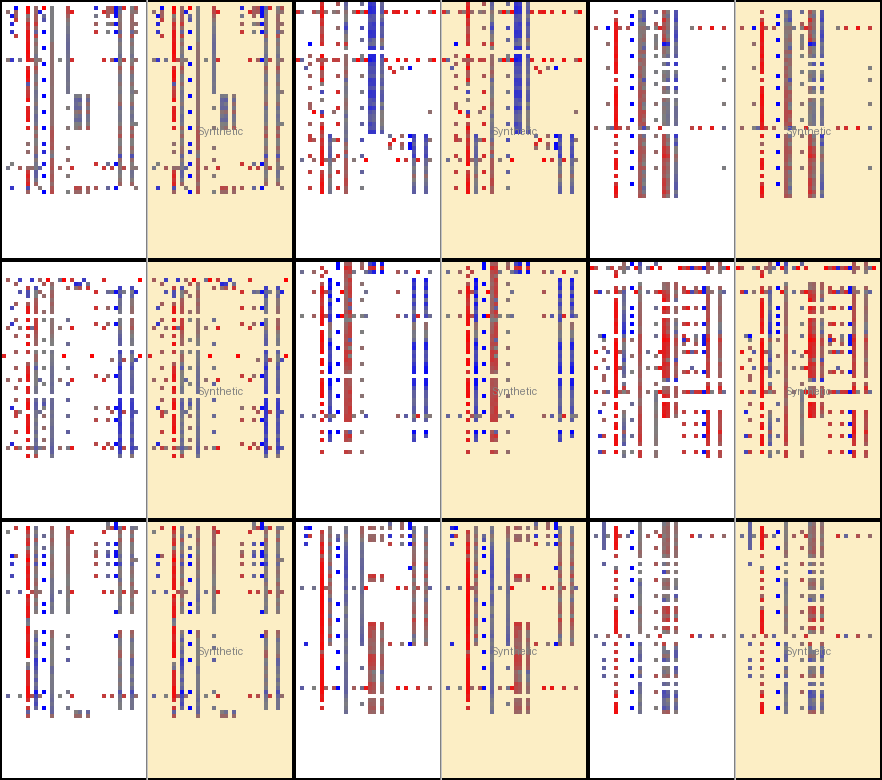

In [57]:
import sys
sys.path.append('../')
from Utils.utils import save_examples


pil_image = save_examples(
        images,
        images,
        n_ts=len(state_vars),
        epoch_no=-1,
    )


# show PIL image, ignore the yellow grids
pil_image
